<a href="https://colab.research.google.com/github/emorysmithis/pupil-cluster/blob/main/BCI_dilation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [70]:
import pandas as pd
import numpy as np
import torch

# Notes from class

could also be interesting to keep track of blinks because of correlations:
- dopamine
- working memory
-


In [71]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [72]:
raw_dataframe = pd.read_csv(
    '/content/drive/MyDrive/Fall 2025/BCI/dilation-dataset/WM study/Eye data/Experiment 1/DWRSS6TET-1040-1.gazedata',
    sep='\t')


In [73]:
raw_dataframe

,Subject,Session,ID,TETTime,RTTime,TimestampSec,TimestampMicrosec,XGazePosLeftEye,YGazePosLeftEye,XCameraPosLeftEye,...,XGazePosRightEye,YGazePosRightEye,XCameraPosRightEye,YCameraPosRightEye,DiameterPupilRightEye,DistanceRightEye,ValidityRightEye,TrialId,NumCorrect,CurrentObject
0,1040,1,1,113065.384,112755,113,65384,-1,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0000,4,1,2,NaN
1,1040,1,2,113073.665,112764,113,73665,-1,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0000,4,1,2,NaN
2,1040,1,3,113081.996,112772,113,81996,-1,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0000,4,1,2,NaN
3,1040,1,4,113090.330,112781,113,90330,-1,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0000,4,1,2,PreTrialBlank
4,1040,1,5,113098.666,112789,113,98666,0.6614372,0.441365,0.703515,...,0.671188,0.610638,0.490636,0.643655,3.529789,720.4445,0,1,2,PreTrialBlank
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56403,1040,1,56404,1256276.587,1255967,1256,276587,-1,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0000,4,80,4,Mask
56404,1040,1,56405,1256284.919,1255975,1256,284919,-1,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0000,4,80,4,Mask
56405,1040,1,56406,1256293.251,1255983,1256,293251,-1,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0000,4,80,4,Mask
56406,1040,1,56407,1256301.583,1255992,1256,301583,-1,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0000,4,80,4,Mask


In [75]:
import glob

all_trial_dataframes = []
for filename in glob.glob('/content/drive/MyDrive/Fall 2025/BCI/dilation-dataset/WM study/Eye data/*/*.gazedata'):
  raw_dataframe = pd.read_csv(
    filename,
    sep='\t',
    low_memory=False)
  # split by trial id
  for trial_id in raw_dataframe['TrialId'].unique():
    trial_dataframe = raw_dataframe[raw_dataframe['TrialId'] == trial_id]

    # drop metadata
    trial_dataframe = trial_dataframe.drop(columns=[
        'Session', 'ID', 'CurrentObject', 'TrialId', 'Subject', 'TETTime', 'RTTime', 'TimestampSec', 'TimestampMicrosec'])

    # TODO: drop specific movements since they will probably not be generalizable
    trial_dataframe = trial_dataframe.drop(columns=[
        'XGazePosLeftEye', 'YGazePosLeftEye', 'XCameraPosLeftEye', 'YCameraPosLeftEye',
        'XGazePosRightEye', 'YGazePosRightEye', 'XCameraPosRightEye', 'YCameraPosRightEye',
        'ValidityRightEye', 'ValidityLeftEye', 'DistanceLeftEye', 'DistanceRightEye'
    ])
    # TODO: decide how to interpolate missing data

    all_trial_dataframes.append(trial_dataframe)

In [76]:
all_trial_dataframes[7]

,DiameterPupilLeftEye,DiameterPupilRightEye,NumCorrect
4936,3.135025,3.286000,3
4937,-1.000000,-1.000000,3
4938,-1.000000,-1.000000,3
4939,3.279978,3.234172,3
4940,3.238501,3.257250,3
...,...,...,...
5635,4.042073,3.944357,3
5636,4.041947,3.937388,3
5637,4.028092,3.936539,3
5638,4.035101,3.969278,3


In [77]:
print(f"Num trials before removing empty and half-empty trials: {len(all_trial_dataframes)}")
# drop trials that are missing more than half of their information
for index, trial in enumerate(all_trial_dataframes):
  if trial.empty:
    all_trial_dataframes.pop(index)
    continue
  if sum(a > 0 for a in trial['DiameterPupilLeftEye']) < len(trial) / 2:
    all_trial_dataframes.pop(index)

print(f"Num trials remaining after removing empty and half-empty trials: {len(all_trial_dataframes)}")

Num trials before removing empty and half-empty trials: 12275
Num trials remaining after removing empty and half-empty trials: 11473


In [ ]:
# TODO: dilation from raw diameter

In [ ]:
# TODO: low pass filter on dilation

In [86]:
# interpolate DiameterPupilLeftEye and DiameterPupilRightEye using MNE
MAX=6
MIN=1
num_linear_fallback = 0
for index, trial in enumerate(all_trial_dataframes):
  # also cutting bad data (e.g. eye partially closed)
  trial["DiameterPupilRightEye"] = trial["DiameterPupilRightEye"].apply(lambda x: np.nan if MAX < x or x < MIN else x)
  trial['DiameterPupilLeftEye'] = trial['DiameterPupilLeftEye'].apply(lambda x: np.nan if MAX < x or x < MIN else x)

  # TODO: need to do something about false values (blink making the percieved pupil diameter look tiny then interpolation making it blow up)
  # dumb way would be to also make values around blinks NanN too
  try:
    all_trial_dataframes[index] = trial.interpolate(method='pchip')
  except:
    num_linear_fallback+=1
    all_trial_dataframes[index] = trial.interpolate()
  #all_trial_dataframes[index]['DiameterPupilRightEye'] = trial['DiameterPupilRightEye'].interpolate()
print(f"failed interpolation and fell back to linear {num_linear_fallback} times")


failed interpolation and fell back to linear 8 times


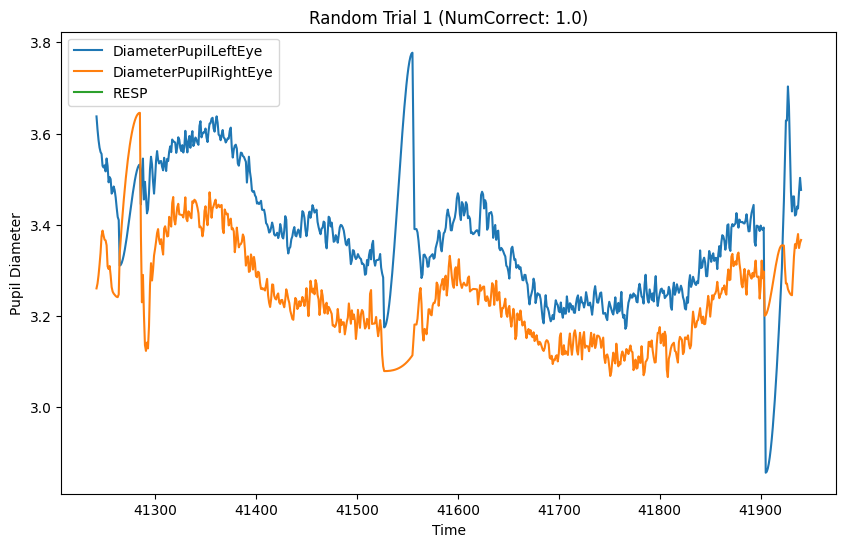

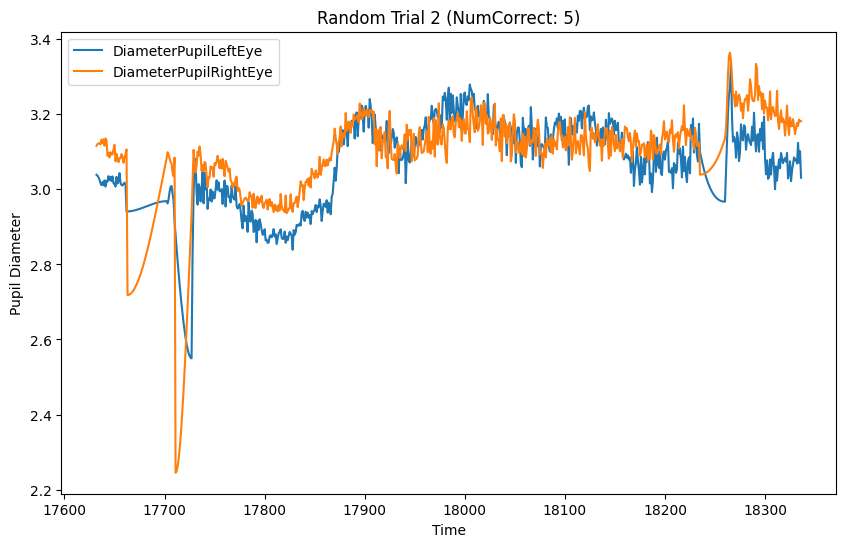

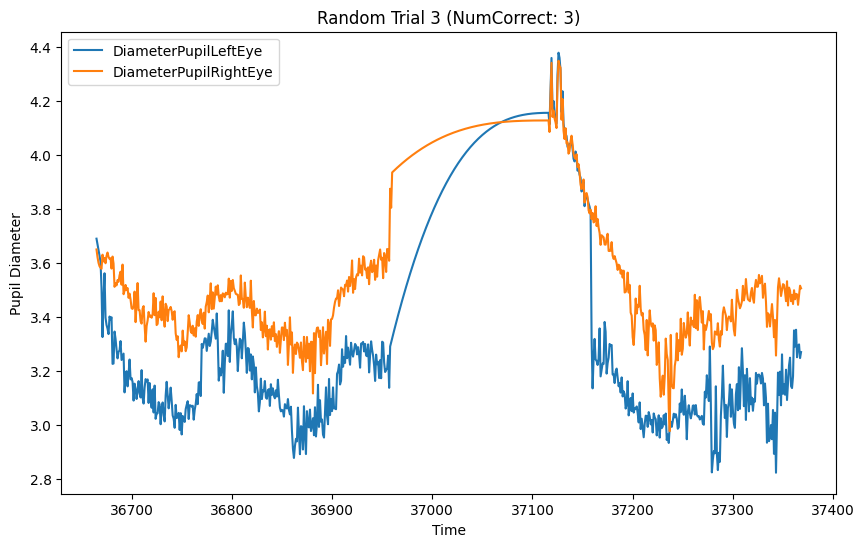

In [87]:
import random
import matplotlib.pyplot as plt

# Select three random trial dataframes
random_trials = random.sample(all_trial_dataframes, 3)

# Plot each trial
for i, trial_df in enumerate(random_trials):
    fig, ax1 = plt.subplots(figsize=(10, 6))

    for column in trial_df.columns:
        if column != 'NumCorrect': # Exclude the label from plotting
          ax1.plot(trial_df.index, trial_df[column], label=column)

    ax1.set_xlabel('Time')
    ax1.set_ylabel('Pupil Diameter')
    plt.title(f'Random Trial {i+1} (NumCorrect: {trial_df["NumCorrect"].iloc[0]})')
    ax1.legend(loc='upper left')
    plt.show()

In [92]:
import matplotlib.pyplot as plt

# Filter dataframes where NumCorrect is 6, only if the dataframe is not empty
trials_with_6_correct = [trial_df for trial_df in all_trial_dataframes if trial_df['NumCorrect'].iloc[0] == 6]

plt.figure(figsize=(12, 7))

# Plot a feature from each filtered trial
# Let's continue using 'DiameterPupilLeftEye' as the feature to plot
feature_to_plot = 'DiameterPupilLeftEye'

for trial_df in trials_with_6_correct:
    # Normalize the x-axis by using the index relative to the start of the trial
    plt.plot(trial_df[feature_to_plot]) #trial_df.index - trial_df.index[0], trial_df[feature_to_plot])


plt.title(f'{feature_to_plot} for Trials with 6 Correct Responses (Normalized X-axis)')
plt.xlabel('Normalized Data Point Index (Relative to Start of Trial)')
plt.ylabel(feature_to_plot)
plt.show()

IndexError: single positional indexer is out-of-bounds

In [81]:
#trial_dataset = TrialDataset(pd.to_numeric(all_trial_dataframes), 50)

In [91]:
#len(trial_dataset)